### DCGAN

source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
from torchvision.utils import make_grid
torch.manual_seed(manualSeed)

Random Seed:  999


In [13]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.figure(figsize=(8,8))
    if show:
        plt.show()

In [3]:
# Root directory for dataset
dataroot = "data/train/"

import os

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Data

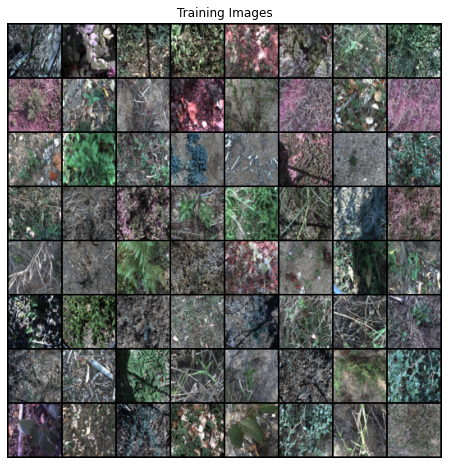

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Implementation

#### Weight Initialization

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### Generator

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#### Loss Function and Optimizers

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/0/%d.png" % batches_done, nrow=n_row, normalize=True)

### Training

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/200][0/137]	Loss_D: 1.6524	Loss_G: 6.9266	D(x): 0.5767	D(G(z)): 0.5731 / 0.0015
[0/200][50/137]	Loss_D: 0.6208	Loss_G: 6.8255	D(x): 0.7493	D(G(z)): 0.1306 / 0.0039
[0/200][100/137]	Loss_D: 0.5569	Loss_G: 2.7462	D(x): 0.7718	D(G(z)): 0.2310 / 0.0741
[1/200][0/137]	Loss_D: 0.8486	Loss_G: 3.1425	D(x): 0.6053	D(G(z)): 0.1789 / 0.0609
[1/200][50/137]	Loss_D: 0.9942	Loss_G: 5.2163	D(x): 0.7275	D(G(z)): 0.4060 / 0.0092
[1/200][100/137]	Loss_D: 0.2969	Loss_G: 5.5577	D(x): 0.7862	D(G(z)): 0.0265 / 0.0059
[2/200][0/137]	Loss_D: 0.2739	Loss_G: 5.0422	D(x): 0.8225	D(G(z)): 0.0634 / 0.0085
[2/200][50/137]	Loss_D: 0.2600	Loss_G: 6.8696	D(x): 0.9415	D(G(z)): 0.1659 / 0.0023
[2/200][100/137]	Loss_D: 0.1817	Loss_G: 5.1609	D(x): 0.9212	D(G(z)): 0.0835 / 0.0085
[3/200][0/137]	Loss_D: 4.0319	Loss_G: 19.9962	D(x): 0.9823	D(G(z)): 0.9761 / 0.0000
[3/200][50/137]	Loss_D: 0.2175	Loss_G: 5.6598	D(x): 0.8969	D(G(z)): 0.0603 / 0.0055
[3/200][100/137]	Loss_D: 0.3734	Loss_G: 5.0140	D(x

[32/200][50/137]	Loss_D: 0.6500	Loss_G: 2.9413	D(x): 0.6184	D(G(z)): 0.0708 / 0.0726
[32/200][100/137]	Loss_D: 0.6779	Loss_G: 4.4955	D(x): 0.8074	D(G(z)): 0.3217 / 0.0183
[33/200][0/137]	Loss_D: 0.5327	Loss_G: 3.6026	D(x): 0.7121	D(G(z)): 0.1244 / 0.0422
[33/200][50/137]	Loss_D: 0.4971	Loss_G: 2.7038	D(x): 0.7013	D(G(z)): 0.0904 / 0.1033
[33/200][100/137]	Loss_D: 0.7520	Loss_G: 2.4202	D(x): 0.5632	D(G(z)): 0.0567 / 0.1333
[34/200][0/137]	Loss_D: 0.5292	Loss_G: 4.0900	D(x): 0.7011	D(G(z)): 0.0945 / 0.0280
[34/200][50/137]	Loss_D: 0.7097	Loss_G: 4.2834	D(x): 0.8478	D(G(z)): 0.3711 / 0.0253
[34/200][100/137]	Loss_D: 0.8461	Loss_G: 4.3882	D(x): 0.8130	D(G(z)): 0.4059 / 0.0192
[35/200][0/137]	Loss_D: 0.7711	Loss_G: 6.0938	D(x): 0.9070	D(G(z)): 0.4340 / 0.0041
[35/200][50/137]	Loss_D: 0.9535	Loss_G: 2.7510	D(x): 0.4770	D(G(z)): 0.0399 / 0.1191
[35/200][100/137]	Loss_D: 0.5163	Loss_G: 3.2220	D(x): 0.7916	D(G(z)): 0.1971 / 0.0570
[36/200][0/137]	Loss_D: 0.8014	Loss_G: 5.8767	D(x): 0.8868	D(G(z

[64/200][100/137]	Loss_D: 0.7565	Loss_G: 6.2386	D(x): 0.8972	D(G(z)): 0.4121 / 0.0031
[65/200][0/137]	Loss_D: 0.5055	Loss_G: 5.1454	D(x): 0.8971	D(G(z)): 0.2675 / 0.0105
[65/200][50/137]	Loss_D: 0.4683	Loss_G: 2.9507	D(x): 0.7400	D(G(z)): 0.0945 / 0.0849
[65/200][100/137]	Loss_D: 0.2511	Loss_G: 4.1254	D(x): 0.9461	D(G(z)): 0.1630 / 0.0250
[66/200][0/137]	Loss_D: 0.2468	Loss_G: 5.0747	D(x): 0.9681	D(G(z)): 0.1688 / 0.0115
[66/200][50/137]	Loss_D: 0.3879	Loss_G: 3.6431	D(x): 0.7880	D(G(z)): 0.0956 / 0.0414
[66/200][100/137]	Loss_D: 0.6005	Loss_G: 3.4673	D(x): 0.6194	D(G(z)): 0.0099 / 0.0531
[67/200][0/137]	Loss_D: 0.4153	Loss_G: 3.9865	D(x): 0.8619	D(G(z)): 0.2016 / 0.0267
[67/200][50/137]	Loss_D: 0.1763	Loss_G: 4.1780	D(x): 0.9462	D(G(z)): 0.1048 / 0.0230
[67/200][100/137]	Loss_D: 0.3269	Loss_G: 4.3037	D(x): 0.8401	D(G(z)): 0.0986 / 0.0213
[68/200][0/137]	Loss_D: 0.5644	Loss_G: 3.9519	D(x): 0.7751	D(G(z)): 0.1886 / 0.0375
[68/200][50/137]	Loss_D: 0.3363	Loss_G: 4.0491	D(x): 0.8475	D(G(z

[97/200][0/137]	Loss_D: 0.4877	Loss_G: 5.7216	D(x): 0.9304	D(G(z)): 0.2927 / 0.0051
[97/200][50/137]	Loss_D: 0.4606	Loss_G: 5.7165	D(x): 0.9493	D(G(z)): 0.2908 / 0.0054
[97/200][100/137]	Loss_D: 0.4619	Loss_G: 3.2462	D(x): 0.7240	D(G(z)): 0.0391 / 0.0821
[98/200][0/137]	Loss_D: 0.2098	Loss_G: 5.0827	D(x): 0.9199	D(G(z)): 0.0985 / 0.0118
[98/200][50/137]	Loss_D: 0.2824	Loss_G: 4.6905	D(x): 0.7987	D(G(z)): 0.0141 / 0.0232
[98/200][100/137]	Loss_D: 0.3950	Loss_G: 3.8335	D(x): 0.8251	D(G(z)): 0.1402 / 0.0338
[99/200][0/137]	Loss_D: 0.2954	Loss_G: 4.1309	D(x): 0.8906	D(G(z)): 0.1336 / 0.0287
[99/200][50/137]	Loss_D: 0.3527	Loss_G: 3.3661	D(x): 0.8062	D(G(z)): 0.0908 / 0.0641
[99/200][100/137]	Loss_D: 0.3814	Loss_G: 2.4445	D(x): 0.7579	D(G(z)): 0.0312 / 0.1776
[100/200][0/137]	Loss_D: 1.1103	Loss_G: 8.7412	D(x): 0.9843	D(G(z)): 0.5490 / 0.0006
[100/200][50/137]	Loss_D: 0.5917	Loss_G: 2.2715	D(x): 0.6359	D(G(z)): 0.0216 / 0.1873
[100/200][100/137]	Loss_D: 0.2507	Loss_G: 3.9126	D(x): 0.8740	D(

[129/200][0/137]	Loss_D: 0.4671	Loss_G: 6.2055	D(x): 0.9744	D(G(z)): 0.3038 / 0.0032
[129/200][50/137]	Loss_D: 0.2473	Loss_G: 4.3335	D(x): 0.9717	D(G(z)): 0.1748 / 0.0201
[129/200][100/137]	Loss_D: 0.2658	Loss_G: 2.7554	D(x): 0.8308	D(G(z)): 0.0486 / 0.1066
[130/200][0/137]	Loss_D: 0.2373	Loss_G: 4.2172	D(x): 0.9473	D(G(z)): 0.1520 / 0.0227
[130/200][50/137]	Loss_D: 0.3365	Loss_G: 2.7857	D(x): 0.8109	D(G(z)): 0.0905 / 0.0923
[130/200][100/137]	Loss_D: 0.1759	Loss_G: 4.1099	D(x): 0.9275	D(G(z)): 0.0854 / 0.0275
[131/200][0/137]	Loss_D: 0.1719	Loss_G: 5.1066	D(x): 0.9676	D(G(z)): 0.1149 / 0.0108
[131/200][50/137]	Loss_D: 0.1577	Loss_G: 4.0796	D(x): 0.9272	D(G(z)): 0.0721 / 0.0269
[131/200][100/137]	Loss_D: 0.3002	Loss_G: 5.4536	D(x): 0.9796	D(G(z)): 0.2106 / 0.0068
[132/200][0/137]	Loss_D: 0.2063	Loss_G: 3.3894	D(x): 0.8535	D(G(z)): 0.0300 / 0.0708
[132/200][50/137]	Loss_D: 0.1257	Loss_G: 4.5346	D(x): 0.9741	D(G(z)): 0.0844 / 0.0201
[132/200][100/137]	Loss_D: 3.2951	Loss_G: 14.1264	D(x):

[161/200][0/137]	Loss_D: 0.4314	Loss_G: 2.4390	D(x): 0.7311	D(G(z)): 0.0138 / 0.1938
[161/200][50/137]	Loss_D: 1.6653	Loss_G: 2.0247	D(x): 0.4354	D(G(z)): 0.1035 / 0.2459
[161/200][100/137]	Loss_D: 0.7325	Loss_G: 4.6442	D(x): 0.7813	D(G(z)): 0.2584 / 0.0229
[162/200][0/137]	Loss_D: 0.2451	Loss_G: 4.5507	D(x): 0.8697	D(G(z)): 0.0694 / 0.0292
[162/200][50/137]	Loss_D: 0.3194	Loss_G: 3.8833	D(x): 0.9070	D(G(z)): 0.1626 / 0.0343
[162/200][100/137]	Loss_D: 0.2764	Loss_G: 4.6760	D(x): 0.9509	D(G(z)): 0.1648 / 0.0156
[163/200][0/137]	Loss_D: 0.1701	Loss_G: 4.3557	D(x): 0.9585	D(G(z)): 0.1046 / 0.0224
[163/200][50/137]	Loss_D: 0.1681	Loss_G: 4.0669	D(x): 0.9231	D(G(z)): 0.0738 / 0.0291
[163/200][100/137]	Loss_D: 0.1547	Loss_G: 3.7804	D(x): 0.9137	D(G(z)): 0.0541 / 0.0424
[164/200][0/137]	Loss_D: 0.1179	Loss_G: 4.5618	D(x): 0.9645	D(G(z)): 0.0723 / 0.0189
[164/200][50/137]	Loss_D: 0.1612	Loss_G: 4.1694	D(x): 0.9452	D(G(z)): 0.0895 / 0.0247
[164/200][100/137]	Loss_D: 0.1096	Loss_G: 4.1749	D(x): 

[193/200][0/137]	Loss_D: 0.0685	Loss_G: 5.0190	D(x): 0.9854	D(G(z)): 0.0484 / 0.0111
[193/200][50/137]	Loss_D: 0.0690	Loss_G: 5.0323	D(x): 0.9792	D(G(z)): 0.0439 / 0.0125
[193/200][100/137]	Loss_D: 0.1259	Loss_G: 5.3613	D(x): 0.9842	D(G(z)): 0.0929 / 0.0079
[194/200][0/137]	Loss_D: 0.1257	Loss_G: 3.8629	D(x): 0.8991	D(G(z)): 0.0127 / 0.0466
[194/200][50/137]	Loss_D: 0.0698	Loss_G: 5.1228	D(x): 0.9548	D(G(z)): 0.0213 / 0.0114
[194/200][100/137]	Loss_D: 1.6014	Loss_G: 1.3423	D(x): 0.4538	D(G(z)): 0.2375 / 0.4312
[195/200][0/137]	Loss_D: 1.1155	Loss_G: 5.7763	D(x): 0.8127	D(G(z)): 0.3876 / 0.0119
[195/200][50/137]	Loss_D: 0.4939	Loss_G: 4.4751	D(x): 0.8206	D(G(z)): 0.1648 / 0.0260
[195/200][100/137]	Loss_D: 0.2894	Loss_G: 4.0379	D(x): 0.8407	D(G(z)): 0.0635 / 0.0495
[196/200][0/137]	Loss_D: 0.2824	Loss_G: 3.3479	D(x): 0.8285	D(G(z)): 0.0530 / 0.0681
[196/200][50/137]	Loss_D: 0.1707	Loss_G: 4.7376	D(x): 0.9459	D(G(z)): 0.0931 / 0.0151
[196/200][100/137]	Loss_D: 0.1516	Loss_G: 4.0610	D(x): 

In [74]:
# Saving the generator model

# Create folder to save model
MODEL_FOLDER = "Model"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/deepweeds_DCGAN_gan_full_dataset.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(netG.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at Model/deepweeds_DCGAN_gan_0.pth


### Evaluate

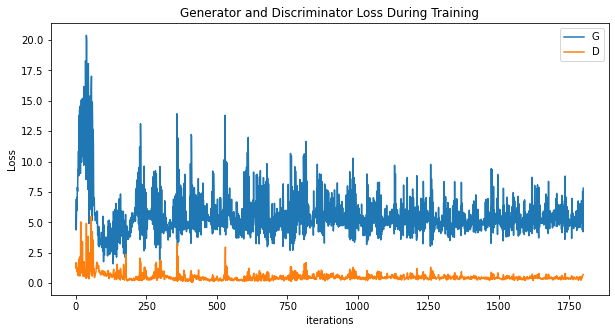

In [75]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

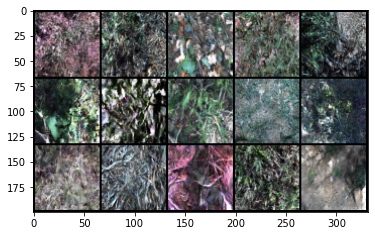

<Figure size 576x576 with 0 Axes>

In [15]:
#View some genaretd images
noise = torch.randn(15, nz, 1, 1, device=device)
        # Generate fake image batch with G
fake = netG(noise)
show_tensor_images(fake, 102)

In [23]:
from torchvision.utils import save_image
def save_sample_image(generator, imgname):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    noise = torch.randn(15, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = generator(noise)
    save_image(fake.data, "data/data_gen_dcgan/{imgname}", nrow=5, normalize=True)
    
#save the sample images
save_sample_image(netG, "10001_generated.png")

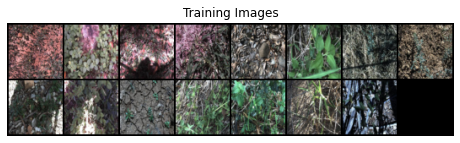

In [22]:
# Plot and save training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:15], padding=2, normalize=True).cpu(),(1,2,0)))

In [25]:
#save the real images

save_image(real_batch[0].to(device)[:15], "data/data_gen_dcgan/10001_real.png", nrow=5, normalize=True)